In [1]:
import os
import glob
import numpy as np
import bokeh.io
import bokeh.plotting
import bokeh.palettes
from bokeh.transform import jitter
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from bokeh.models import HoverTool, Range1d
from scipy import stats
import pandas as pd
import math

from bokeh.layouts import row
bokeh.io.output_notebook()


Loading BokehJS ...

In [2]:
def getProbs(csv_file, save_csv_name, tot_pili_limit, nb_pili_differences, strain):
    df_raw = pd.read_csv(csv_file, sep=',', na_values='*')
    df_full = df_raw.loc[df_raw['Strain'] == strain]
    df_full['TotalPili']=df_full['Nb_Pili_PoleBright']+df_full['Nb_Pili_PoleDim']
    df = df_full.loc[df_full['TotalPili'] > 1]
    df['DeltaPili']=(df['Nb_Pili_PoleBright']-df['Nb_Pili_PoleDim']).abs()
    a=[None]*tot_pili_limit
    b=[None]*tot_pili_limit
    n=[None]*tot_pili_limit
    assym=[None]*tot_pili_limit
    probs=np.zeros([nb_pili_differences,tot_pili_limit])
    for n_pili in range(tot_pili_limit):
        df_temp=df.loc[df['TotalPili'] == n_pili+2]
        n[n_pili]=len(df_temp)
        if(n[n_pili]>0):
            a[n_pili]=len(df_temp.loc[df['DeltaPili'] == 0])
            b[n_pili]=len(df_temp.loc[df['DeltaPili'] > 0])
            assym[n_pili]=b[n_pili]/n[n_pili]
            for delta in range(nb_pili_differences):
                #print('For '+ str(delta)+' pili difference, there are '+str(len(df_temp.loc[df_temp['DeltaPili'] == delta]))+' cells and '+str(n[n_pili])+' cells that have '+str(n_pili+2)+'pili')
                probs[delta, n_pili]=len(df_temp.loc[df_temp['DeltaPili'] == delta])/n[n_pili]
        else:
            assym[n_pili]=0
            for delta in range(nb_pili_differences):
                probs[delta, n_pili]=0
            
    pili=np.arange(2,tot_pili_limit+2)
    df_probs=pd.DataFrame(probs, columns = list(pili))
    df_probs.to_csv( save_csv_name, index=False, encoding='utf-8-sig')
    return pili, assym, n, probs, df_probs

def concatCsv(data_path, root_path, new_dir, save_name):
    os.chdir(data_path)
    extension = 'csv'
    list_csv = []
    for root, dirs, files in os.walk(data_path, topdown=False):
        for name in files:
            if extension in name:
                list_csv.append(os.path.join(root, name))
    #os.chdir("C:/users/tala/git/PhD_codes/Mechanosensation/Python_code/Pole_analysis/")
    #print(list_csv)
    os.chdir(root_path)
    new_dir_path = os.path.join(root_path, new_dir)
    if not os.path.exists(new_dir_path):
        os.mkdir(new_dir_path)
    os.chdir(new_dir_path)
    combined_csv_raw = pd.concat([pd.read_csv(f) for f in list_csv ], sort=False)
    combined_csv=combined_csv_raw.loc[(combined_csv_raw['Label'] != 'Mask1') & (combined_csv_raw['Label'] != 'Mask0') & (~pd.isnull(combined_csv_raw['Label'])) & (combined_csv_raw['PolarRatio'] != 0)]
    combined_csv.to_csv( save_name, index=False, encoding='utf-8-sig')
    raw_names=list(combined_csv.Label.unique())
    #print(len(raw_names))
    #print(raw_names)
    Combine_Data=False
    if not Combine_Data:
        combined_csv['Strain'] = 'nan'
        combined_csv['Growth'] = 'nan'
        for file in raw_names:
            #print(file)
            split_name=file.rsplit('_event',100)[0].rsplit('_',100)
            if 'Agarose' in file or 'sol' in file or 'Agar' in file:
                #print('YES!!!')
                growth='Solid'
                if 'Agarose' in split_name:
                    growthInd = split_name.index('Agarose')
                elif 'sol' in split_name:
                    growthInd = split_name.index('sol')
                elif 'solid' in split_name:
                    growthInd = split_name.index('solid')
                elif 'Agar' in split_name:
                    growthInd = split_name.index('Agar')
            else:
                growth='Liquid'
                if 'liq' in split_name:
                    growthInd = split_name.index('liq')
                else:
                    growthInd = len(split_name)-3
            separator = '-'
            #strain =  separator.join(split_name[0:growthInd])
            strain_raw =  split_name[0].rsplit('-',100)
            for i in range(len(strain_raw)-1):
                strain_raw[i]=capitalize_nth(strain_raw[i],len(strain_raw[i])-1)
            strain=separator.join(strain_raw)
            combined_csv.Strain.loc[(combined_csv['Label']==file)]=strain
            combined_csv.Growth.loc[(combined_csv['Label']==file)]=growth
    combined_csv.to_csv( save_name, index=False, encoding='utf-8-sig')
    return combined_csv

def polar_plot(proba, ref_proba, range_pili, range_dif, strain):
    fig1=plt.figure(figsize=(10, 6))
    ax1 = fig1.add_axes([0.1,0.1,0.8,0.8],polar=True)
    actual=np.sum(proba[range_dif[0]:range_dif[1],range_pili[0]:range_pili[1]], axis=0)
    expected=np.sum(ref_proba[range_dif[0]:range_dif[1],range_pili[0]:range_pili[1]], axis=0)
    employee = [None]*len(actual)
    for i, pili in enumerate(n_pili[range_pili[0]:range_pili[1]]):
        employee[i] = str(pili) + '_pili'
    # Initialise the spider plot by setting figure size and polar projection
    theta = np.linspace(0, 2*np.pi, len(employee))
    # Arrange the grid into number of sales equal parts in degrees
    lines, labels = plt.thetagrids(range(0, 360, int(360/(len(employee)-1))), (employee))
    # Plot actual sales graph
    plt.plot(theta, actual)
    plt.fill(theta, actual, 'b', alpha=0.1)
    # Plot expected sales graph
    plt.plot(theta, expected)
    # Add legend and title for the plot
    plt.legend(labels=(strain, 'Expected'), loc=1)
    plt.title("Actual vs Expected probability of symetric cells")
    ax1.set_ylim(0,1)
    # Dsiplay the plot on the screen
    plt.show()
    save_name=strain+'.svg'
    fig1.savefig(save_name, dpi=300)
    
def plot_pili_comparison(ax, pili_number, diff_number, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs_pilHcyaBfliC, probs, y_label):
    ax.set_ylim(0,1)
    ax.set_xlim(0,5)
    ind_row=diff_number+1
    ind_col=pili_number-2
    ax.plot(1, np.sum(probs_fliC[slice(ind_row),ind_col], axis=0), 'ok')
    ax.plot(2, np.sum(probs_pilGcpdAfliC[slice(ind_row),ind_col], axis=0), 'og')
    ax.plot(3, np.sum(probs_cpdAfliC[slice(ind_row),ind_col], axis=0), 'oc')
    ax.plot(4, np.sum(probs_pilHcyaBfliC[slice(ind_row),ind_col], axis=0), 'om')
    ref_prob=np.ones(6)*np.sum(probs[slice(ind_row),ind_col], axis=0)
    ax.plot([0,1,2,3,4,5],ref_prob, 'r')
    #plt.legend(labels=('fliC-', 'pilGcpdAfliC', 'cpdAfliC', 'Expected'), loc=1)
    ax.set(ylabel=y_label)
    ax.set(xticklabels=['', 'fliC-', 'pilG-cpdA-fliC-', 'cpdA-fliC-', 'pilH-cyaB-fliC-', ''])
    ax.tick_params(axis='x', rotation=45)
    ax.set(title="Cells with "+str(pili_number)+" pili")

def capitalize_nth(s, n):
    return s[:n].lower() + s[n:].capitalize()

In [3]:
#df_fliC = concatCsv('G:/Sauvegardes PhD/Covid-19/Pili_and_PaQa_counts_data/PaQa_data/fliC-', "C:/users/tala/Desktop/git/PhD_codes/Mechanosensation/Python_code/Pole_analysis/Assymetry_data/", "fliC-", "Pili_PaQa_Data_fliC-_New.csv")
df_tot = concatCsv('F:\Sauvegardes PhD\Covid-19\Assymetry\Data', "C:/Users/Iscia/Desktop/git/PhD_codes/Mechanosensation/Python_code/Assymetry_data/", "Final_Data", "combined_data.csv")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'F:\\Sauvegardes PhD\\Covid-19\\Assymetry\\Data'

In [3]:
df=pd.read_csv("C:/Users/lorenzo/Desktop/git/PhD_codes/Mechanosensation/Python_code/Assymetry_data/Final_Data/combined_data.csv", sep=',', na_values='*')
df_2=pd.read_csv("C:/Users/lorenzo/Desktop/git/PhD_codes/Mechanosensation/Python_code/Assymetry_data/fliC-/Pili_PaQa_Data_fliC-_New.csv", sep=',', na_values='*')
df_short=pd.concat([df, df_2], sort=False)
df_short.to_csv( "C:/Users/lorenzo/Desktop/git/PhD_codes/Mechanosensation/Python_code/Assymetry_data/Combined_all_data.csv", index=False, encoding='utf-8-sig')
df_short.head()



,,Label,Area,Mean,Min,Max,X,Y,BiologicalReplicate,CellArea,...,Cell_ID,RetractedPilusLength_Dim,RetractedPilusFrame_Dim,RetractedPilusLength_Bright,RetractedPilusFrame_Bright,StdDev,Median,Slice,Strain,Growth
0,1.0,CpdA-FLiC-_2_Microchannel_0_event2_tirf_RAW_St...,1208.0,255.0,255.0,255.0,32.13576,43.83030,1.0,1310.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cpdA-fliC-,Liquid
1,1.0,CpdA-FLiC-_2_Microchannel_0_event3_tirf_RAW_St...,2250.0,255.0,255.0,255.0,73.56222,31.29600,1.0,2405.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cpdA-fliC-,Liquid
2,1.0,CpdA-FLiC-_2_Microchannel_1_event2_tirf_RAW_St...,7524.0,255.0,255.0,255.0,46.00864,45.05622,1.0,7706.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cpdA-fliC-,Liquid
3,1.0,CpdA-FLiC-_2_Microchannel_1_event3_tirf_RAW_St...,1698.0,255.0,255.0,255.0,21.60542,51.71673,1.0,1806.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cpdA-fliC-,Liquid
4,1.0,CpdA-FLiC-_2_Microchannel_3_event3_tirf_RAW_St...,3112.0,255.0,255.0,255.0,57.22333,28.92898,1.0,3322.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cpdA-fliC-,Liquid


In [5]:
tot_pili_limit=20
nb_pili_difference=20
master_file="C:/Users/lorenzo/Desktop/git/PhD_codes/Mechanosensation/Python_code/Assymetry_data/Combined_all_data.csv"
os.chdir("C:/users/lorenzo/Desktop/git/PhD_codes/Mechanosensation/Python_code/Assymetry_data/")
pili_fliC, assym_fliC, n_fliC, probs_fliC, df_probs_fliC =getProbs(master_file, "fliCsol_piliDistProb.csv", tot_pili_limit, nb_pili_difference, 'fliC-')
print('Assymetric fliC-')
print(np.array(n_fliC).sum())
print(n_fliC)
print(pili_fliC)
print(assym_fliC)

pili_pilHfliC, assym_pilHfliC, n_pilHfliC, probs_pilHfliC, df_probs_pilHfliC =getProbs(master_file, "pilHfliCsol_piliDistProb.csv", tot_pili_limit, nb_pili_difference, 'pilH-fliC-')
print('Assymetric pilH-fliC-')
print(np.array(n_pilHfliC).sum())
print(n_pilHfliC)
print(pili_pilHfliC)
print(assym_pilHfliC)

pili_pilHcyaBfliC, assym_pilHcyaBfliC, n_pilHcyaBfliC, probs_pilHcyaBfliC, df_probs_pilHcyaBfliC =getProbs(master_file, "pilHcyaBfliCsol_piliDistProb.csv", tot_pili_limit, nb_pili_difference, 'pilH-cyaB-fliC-')
print('Assymetric pilH-cyaB-fliC-')
print(np.array(n_pilHcyaBfliC).sum())
print(n_pilHcyaBfliC)
print(pili_pilHcyaBfliC)
print(assym_pilHcyaBfliC)

pili_cpdAfliC, assym_cpdAfliC, n_cpdAfliC, probs_cpdAfliC, df_probs_cpdAfliC =getProbs(master_file, "cpdAfliCsol_piliDistProb.csv", tot_pili_limit, nb_pili_difference, 'cpdA-fliC-')
print('Assymetric cpdA-fliC-')
print(np.array(n_cpdAfliC).sum())
print(n_cpdAfliC)
print(pili_cpdAfliC)
print(assym_cpdAfliC)

pili_pilGcpdAfliC, assym_pilGcpdAfliC, n_pilGcpdAfliC, probs_pilGcpdAfliC, df_probs_pilGcpdAfliC =getProbs(master_file, "pilGcpdAfliCsol_piliDistProb.csv", tot_pili_limit, nb_pili_difference, 'pilG-cpdA-fliC-')
print('Assymetric pilG-cpdA-fliC-')
print(np.array(n_pilGcpdAfliC).sum())
print(n_pilGcpdAfliC)
print(pili_pilGcpdAfliC)
print(assym_pilGcpdAfliC)

<ipython-input-2-123475f19044>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['TotalPili']=df_full['Nb_Pili_PoleBright']+df_full['Nb_Pili_PoleDim']
<ipython-input-2-123475f19044>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DeltaPili']=(df['Nb_Pili_PoleBright']-df['Nb_Pili_PoleDim']).abs()


Assymetric fliC-
97
[19, 24, 16, 13, 11, 6, 3, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[0.42105263157894735, 1.0, 0.8125, 1.0, 0.9090909090909091, 1.0, 0.6666666666666666, 1.0, 1.0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0]


<ipython-input-2-123475f19044>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['TotalPili']=df_full['Nb_Pili_PoleBright']+df_full['Nb_Pili_PoleDim']


Assymetric pilH-fliC-
70
[0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 7, 6, 9, 13, 13, 6, 3, 4, 4]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[0, 0, 0, 0, 0, 0, 0, 1.0, 0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.6923076923076923, 1.0, 0.8333333333333334, 1.0, 0.75, 1.0]
Assymetric pilH-cyaB-fliC-
70
[29, 11, 17, 5, 3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[0.6206896551724138, 1.0, 0.5882352941176471, 1.0, 0.6666666666666666, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<ipython-input-2-123475f19044>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['TotalPili']=df_full['Nb_Pili_PoleBright']+df_full['Nb_Pili_PoleDim']
<ipython-input-2-123475f19044>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DeltaPili']=(df['Nb_Pili_PoleBright']-df['Nb_Pili_PoleDim']).abs()
<ipython-input-2-123475f19044>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Assymetric cpdA-fliC-
109
[4, 8, 11, 18, 16, 10, 8, 6, 4, 7, 3, 4, 3, 3, 2, 2, 0, 0, 0, 0]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[0.5, 1.0, 0.6363636363636364, 1.0, 0.6875, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 0, 0, 0, 0]
Assymetric pilG-cpdA-fliC-
48
[24, 11, 7, 3, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[0.08333333333333333, 1.0, 0.0, 1.0, 0, 1.0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<ipython-input-2-123475f19044>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['TotalPili']=df_full['Nb_Pili_PoleBright']+df_full['Nb_Pili_PoleDim']
<ipython-input-2-123475f19044>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DeltaPili']=(df['Nb_Pili_PoleBright']-df['Nb_Pili_PoleDim']).abs()


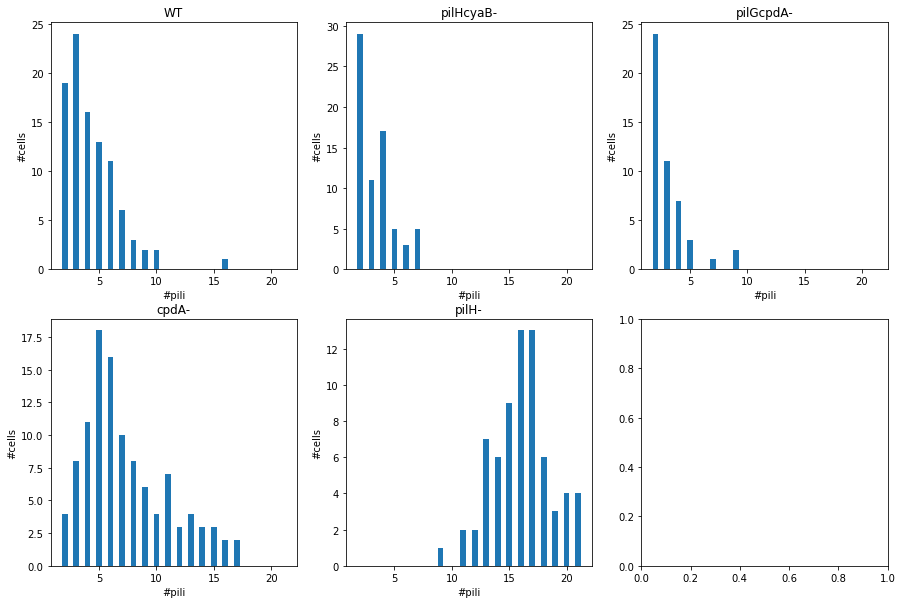

In [6]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) =plt.subplots(2,3)
fig.set_size_inches(15, 10)

plt.subplot(2, 3, 1)
plt.bar(pili_fliC,n_fliC, width = 0.5, align='center')
plt.title('WT')
plt.xlabel('#pili')
plt.ylabel('#cells')
plt.subplot(2, 3, 2)
plt.bar(pili_pilHcyaBfliC,n_pilHcyaBfliC, width = 0.5, align='center')
plt.title('pilHcyaB-')
plt.xlabel('#pili')
plt.ylabel('#cells')
plt.subplot(2, 3, 3)
plt.bar(pili_pilGcpdAfliC,n_pilGcpdAfliC, width = 0.5, align='center')
plt.title('pilGcpdA-')
plt.xlabel('#pili')
plt.ylabel('#cells')
plt.subplot(2, 3, 4)
plt.bar(pili_cpdAfliC,n_cpdAfliC, width = 0.5, align='center')
plt.title('cpdA-')
plt.xlabel('#pili')
plt.ylabel('#cells')
plt.subplot(2, 3, 5)
plt.bar(pili_pilHfliC,n_pilHfliC, width = 0.5, align='center')
plt.title('pilH-')
plt.xlabel('#pili')
plt.ylabel('#cells')

fig.savefig('pili_Distribution.svg', dpi=300)

In [8]:
n_pili=np.linspace(2,tot_pili_limit+1, 20, dtype=np.int16)
n_pil=np.linspace(0,tot_pili_limit+1,22, dtype=np.int16)
diff_even=n_pil[0::2]
diff_odd=n_pil[1::2]
probs=np.zeros([nb_pili_difference,tot_pili_limit])
for val, i in enumerate(n_pil[2:]):
    if (i % 2 == 0):
        diff=diff_even[diff_even<=i]
    else:
        diff=diff_odd[diff_odd<=i]
    for j, d in enumerate(diff):
        if (i % 2 == 0):
            k=i/2+j
            index=j*2
            if ((index<tot_pili_limit)):
                if(j==0):
                    probs[index, val]=math.factorial(i)/math.factorial(i-k)/math.factorial(k)/2
                else:
                    probs[index, val]=math.factorial(i)/math.factorial(i-k)/math.factorial(k)
        else:
            k=i-(j*2+1)
            #print('i='+str(i)+ ' k='+str(k))
            index=1+j*2
            if ((index<tot_pili_limit) & (k<=i)):
                probs[index, val]=math.factorial(i)/math.factorial(i-k)/math.factorial(k)
for i in range(tot_pili_limit):
    probs[:,i]=probs[:,i]/np.sum(probs[:,i])
pili=np.arange(2,tot_pili_limit+2)
df_stat=pd.DataFrame(probs, columns = list(pili))
df_stat.to_csv( "C:/Users/lorenzo/Desktop/git/PhD_codes/Mechanosensation/Python_code/Assymetry_data/Ref_Stat_data.csv", index=False, encoding='utf-8-sig')
df_stat.head(100)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.5,0.00,0.375,0.0000,0.31250,0.000000,0.273438,0.000000,0.246094,0.000000,0.225586,0.000000,0.209473,0.000000,0.196381,0.000000,0.185471,0.000000,0.176197,0.000000
1,0.0,0.75,0.000,0.3125,0.00000,0.109375,0.000000,0.035156,0.000000,0.010742,0.000000,0.003174,0.000000,0.000916,0.000000,0.000259,0.000000,0.000072,0.000000,0.000020
2,0.5,0.00,0.500,0.0000,0.46875,0.000000,0.437500,0.000000,0.410156,0.000000,0.386719,0.000000,0.366577,0.000000,0.349121,0.000000,0.333847,0.000000,0.320359,0.000000
3,0.0,0.25,0.000,0.6250,0.00000,0.546875,0.000000,0.328125,0.000000,0.161133,0.000000,0.069824,0.000000,0.027771,0.000000,0.010376,0.000000,0.003696,0.000000,0.001268
4,0.0,0.00,0.125,0.0000,0.18750,0.000000,0.218750,0.000000,0.234375,0.000000,0.241699,0.000000,0.244385,0.000000,0.244385,0.000000,0.242798,0.000000,0.240269,0.000000
5,0.0,0.00,0.000,0.0625,0.00000,0.328125,0.000000,0.492188,0.000000,0.451172,0.000000,0.314209,0.000000,0.183289,0.000000,0.094421,0.000000,0.044357,0.000000,0.019406
6,0.0,0.00,0.000,0.0000,0.03125,0.000000,0.062500,0.000000,0.087891,0.000000,0.107422,0.000000,0.122192,0.000000,0.133301,0.000000,0.141632,0.000000,0.147858,0.000000
7,0.0,0.00,0.000,0.0000,0.00000,0.015625,0.000000,0.140625,0.000000,0.322266,0.000000,0.418945,0.000000,0.392761,0.000000,0.296753,0.000000,0.192215,0.000000,0.110893
8,0.0,0.00,0.000,0.0000,0.00000,0.000000,0.007812,0.000000,0.019531,0.000000,0.032227,0.000000,0.044434,0.000000,0.055542,0.000000,0.065369,0.000000,0.073929,0.000000
9,0.0,0.00,0.000,0.0000,0.00000,0.000000,0.000000,0.003906,0.000000,0.053711,0.000000,0.174561,0.000000,0.305481,0.000000,0.370941,0.000000,0.352394,0.000000,0.280314


strain:0
[100.0, None, None]
[100.0, 50.0, None]
[100.0, 50.0, 125.0]
strain:1
[8.0, None, None]
[8.0, 7.0, None]
[8.0, 7.0, 13.0]
strain:2
[2.0, None, None]
[2.0, 3.0, None]
[2.0, 3.0, 7.0]
strain:3
[2.0, None, None]
[2.0, 1.0, None]
[2.0, 1.0, 0.0]
strain:4
[18.0, None, None]
[18.0, 8.0, None]
[18.0, 8.0, 10.0]
[0.4583333333333333, 0.4745762711864407, 0.5217391304347826, 0.07142857142857142, 0.631578947368421]


<ipython-input-9-e15f720568e9>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_)


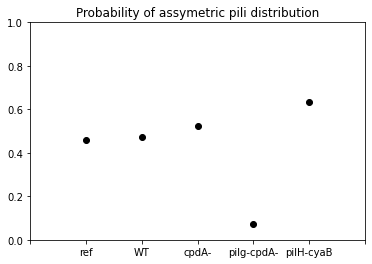

In [9]:
input_cell_nb_array=list([[200, 200, 200], n_fliC, n_cpdAfliC, n_pilGcpdAfliC, n_pilHcyaBfliC]) 
input_probability_DataFrame=list([df_stat, df_probs_fliC, df_probs_cpdAfliC, df_probs_pilGcpdAfliC, df_probs_pilHcyaBfliC])
tot_assymetric=[None]*len(input_cell_nb_array)
for strain in range(len(tot_assymetric)):
    print('strain:'+str(strain))
    input_probability_matrix=np.array(input_probability_DataFrame[strain])
    tot_cells=np.sum(input_cell_nb_array[strain][0:3])
    cell=[None]*3
    for i in range(3):
        cell[i]=np.sum(input_probability_matrix[2:5,i]*input_cell_nb_array[strain][i])
        print(cell)
    tot_assymetric[strain]=np.sum(cell)/tot_cells
print(tot_assymetric)
fig1, ax1=plt.subplots(1,1)
fig.set_size_inches(15, 4)
ax1.set_ylim(0,1)
ax1.set_xlim(0,len(tot_assymetric)+1)
x=np.arange(1,len(tot_assymetric)+1)
x_=['','ref', 'WT', 'cpdA-', 'pilg-cpdA-', 'pilH-cyaB']
plt.plot(x,tot_assymetric, 'ok')
ax1.set_xticklabels(x_)
plt.title("Probability of assymetric pili distribution")
save_name='assymetric_probability_barplot.svg'
fig1.savefig(save_name, dpi=300)

ZeroDivisionError: division by zero

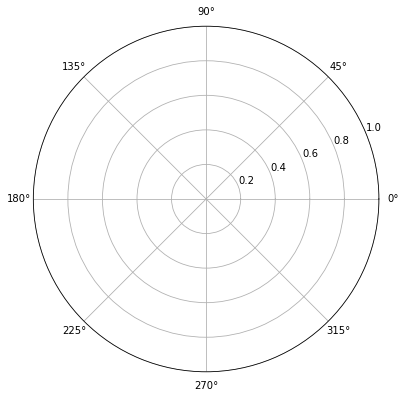

In [16]:
polar_plot(probs_fliC, probs, [1, 2], [0, 2], 'fliC-')
polar_plot(probs_pilGcpdAfliC, probs, [0, 4], [0, 2], 'pilG-cpdA-fliC-')
polar_plot(probs_cpdAfliC, probs, [1, 7], [0, 2], 'cpdA-fliC-')
polar_plot(probs_pilHfliC, probs, [11, 17], [0, 2], 'pilH-fliC-')
polar_plot(probs_pilHcyaBfliC, probs, [0, 5], [0, 2], 'pilH-cyaB-fliC-')

<ipython-input-2-123475f19044>:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['', 'fliC-', 'pilG-cpdA-fliC-', 'cpdA-fliC-', 'pilH-cyaB-fliC-', ''])
<ipython-input-2-123475f19044>:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['', 'fliC-', 'pilG-cpdA-fliC-', 'cpdA-fliC-', 'pilH-cyaB-fliC-', ''])
<ipython-input-2-123475f19044>:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['', 'fliC-', 'pilG-cpdA-fliC-', 'cpdA-fliC-', 'pilH-cyaB-fliC-', ''])


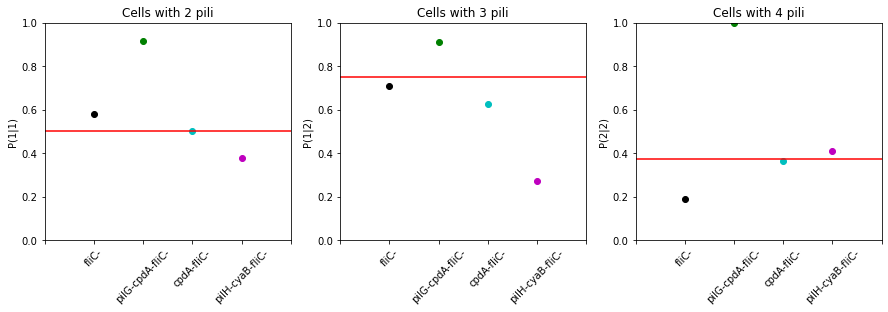

In [17]:
fig, ax =plt.subplots(1,3)
fig.set_size_inches(15, 4)
plot_pili_comparison(ax[0], 2, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs_pilHcyaBfliC, probs, 'P(1|1)')
plot_pili_comparison(ax[1], 3, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs_pilHcyaBfliC, probs, 'P(1|2)')
plot_pili_comparison(ax[2], 4, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs_pilHcyaBfliC, probs, 'P(2|2)')

fig.savefig('2-3-4_pili.svg', dpi=300)

In [ ]:
plot_pili_comparison(ax[0,3], 5, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs, 'P(2|3)')
plot_pili_comparison(ax[0,4], 6, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs, 'P(3|3)')
plot_pili_comparison(ax[0,5], 7, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs, 'P(3|4)')

plot_pili_comparison(ax[1,0], 8, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs, 'P(4|4)')
plot_pili_comparison(ax[1,1], 9, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs_pilHfliC, probs, 'P(4|5)')
plot_pili_comparison(ax[1,2], 10, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs_pilHfliC, probs, 'P(5|5)')
plot_pili_comparison(ax[1,3], 11, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs_pilHfliC, probs, 'P(5|6)')
plot_pili_comparison(ax[1,4], 12, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs_pilHfliC, probs, 'P(6|6)')
plot_pili_comparison(ax[1,5], 13, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs_pilHfliC, probs, 'P(6|7)')

plot_pili_comparison(ax[2,0], 14, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs_pilHfliC, probs, 'P(7|7)')
plot_pili_comparison(ax[2,1], 15, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs_pilHfliC, probs, 'P(7|8)')
plot_pili_comparison(ax[2,2], 16, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs_pilHfliC, probs, 'P(8|8)')
plot_pili_comparison(ax[2,3], 17, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs_pilHfliC, probs, 'P(8|9)')
plot_pili_comparison(ax[2,4], 18, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs_pilHfliC, probs, 'P(9|9)')
plot_pili_comparison(ax[2,5], 19, 1, probs_fliC, probs_pilGcpdAfliC, probs_cpdAfliC, probs_pilHfliC, probs, 'P(9|10)')


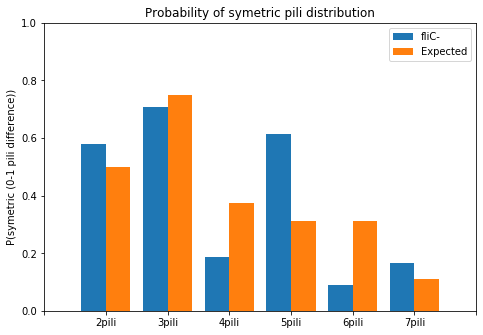

In [117]:
fig1=plt.figure()
ax1 = fig1.add_axes([0,0,1,1])
ax1.set_ylim(0,1)
ax1.set_xlim(-1,6)
ind_row=0
ind_col=0
x_fliC=['2pili', '3pili', '4pili', '5pili', '6pili','7pili']
x=np.arange(6)
y_fliC=[None]*(7-2+1)
for i in range(len(y_fliC)):
    y_fliC[i]=np.sum(probs_fliC[slice(2),ind_col+i])
    
y_ref=[None]*(7-2+1)
for i in range(len(y_fliC)):
    y_ref[i]=np.sum(probs[slice(2),ind_col+i])

plt.bar(x-0.2,y_fliC, width = 0.4, align='center')
plt.bar(x+0.2,y_ref, width = 0.4, align='center')
plt.legend(labels=('fliC-','Expected'), loc=1)
plt.ylabel('P(symetric (0-1 pili difference))')
ax1.set_xticklabels(['', '2pili', '3pili', '4pili', '5pili', '6pili', '7pili'])
plt.title("Probability of symetric pili distribution")
save_name='fliC-barplot.svg'
fig1.savefig(save_name, dpi=300)

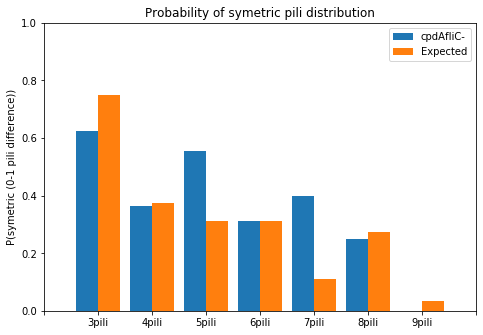

In [118]:
fig1=plt.figure()
ax1 = fig1.add_axes([0,0,1,1])
ax1.set_ylim(0,1)
ax1.set_xlim(-1,7)
ind_row=0
ind_col=0
x_cpdAfliC=['2pili', '3pili', '4pili', '5pili', '6pili','7pili']
x=np.arange(7)
y_cpdAfliC=[None]*7
for i in range(len(y_cpdAfliC)):
    y_cpdAfliC[i]=np.sum(probs_cpdAfliC[slice(2),ind_col+i+1])
    
y_ref=[None]*7
for i in range(len(y_cpdAfliC)):
    y_ref[i]=np.sum(probs[slice(2),ind_col+i+1])

plt.bar(x-0.2,y_cpdAfliC, width = 0.4, align='center')
plt.bar(x+0.2,y_ref, width = 0.4, align='center')
plt.legend(labels=('cpdAfliC-','Expected'), loc=1)
plt.ylabel('P(symetric (0-1 pili difference))')
ax1.set_xticklabels(['', '3pili', '4pili', '5pili', '6pili', '7pili', '8pili', '9pili'])
plt.title("Probability of symetric pili distribution")
save_name='cpdAfliC-barplot.svg'
fig1.savefig(save_name, dpi=300)

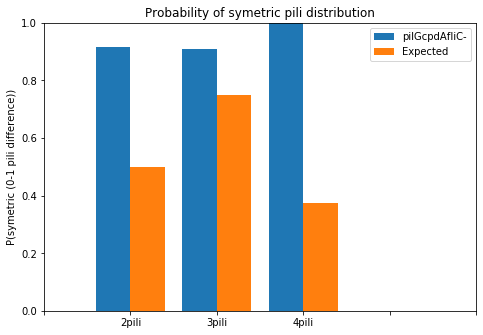

In [121]:
fig1=plt.figure()
ax1 = fig1.add_axes([0,0,1,1])
ax1.set_ylim(0,1)
ax1.set_xlim(-1,4)
ind_row=0
ind_col=0
x_cpdAfliC=['2pili', '3pili', '4pili', '5pili', '6pili','7pili']
x=np.arange(3)
y_pilGcpdAfliC=[None]*3
for i in range(len(y_pilGcpdAfliC)):
    y_pilGcpdAfliC[i]=np.sum(probs_pilGcpdAfliC[slice(2),ind_col+i])
    
y_ref=[None]*3
for i in range(len(y_ref)):
    y_ref[i]=np.sum(probs[slice(2),ind_col+i])

plt.bar(x-0.2,y_pilGcpdAfliC, width = 0.4, align='center')
plt.bar(x+0.2,y_ref, width = 0.4, align='center')
plt.legend(labels=('pilGcpdAfliC-','Expected'), loc=1)
plt.ylabel('P(symetric (0-1 pili difference))')
ax1.set_xticklabels(['', '2pili', '3pili', '4pili'])
plt.title("Probability of symetric pili distribution")
save_name='pilGcpdAfliC-barplot.svg'
fig1.savefig(save_name, dpi=300)

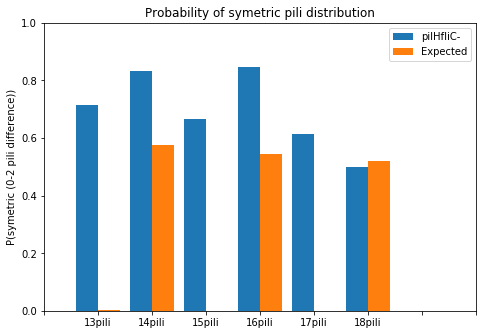

In [120]:
fig1=plt.figure()
ax1 = fig1.add_axes([0,0,1,1])
ax1.set_ylim(0,1)
ax1.set_xlim(-1,7)
ind_row=0
ind_col=11
x_cpdAfliC=['2pili', '3pili', '4pili', '5pili', '6pili','7pili']
x=np.arange(6)
y_pilHfliC=[None]*6
for i in range(len(y_pilHfliC)):
    y_pilHfliC[i]=np.sum(probs_pilHfliC[slice(3),ind_col+i])
    
y_ref=[None]*6
for i in range(len(y_pilHfliC)):
    y_ref[i]=np.sum(probs[slice(3),ind_col+i])

plt.bar(x-0.2,y_pilHfliC, width = 0.4, align='center')
plt.bar(x+0.2,y_ref, width = 0.4, align='center')
plt.legend(labels=('pilHfliC-','Expected'), loc=1)
plt.ylabel('P(symetric (0-2 pili difference))')
ax1.set_xticklabels(['', '13pili', '14pili', '15pili', '16pili', '17pili', '18pili'])
plt.title("Probability of symetric pili distribution")
save_name='pilHfliC-barplot.svg'
fig1.savefig(save_name, dpi=300)